# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair): group F
- [Student 1]([link](https://github.com/Ptiroro)) : Romain BOQUET
- [Student 2]([link](https://github.com/DubusA)) : Antoine DUBUS

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

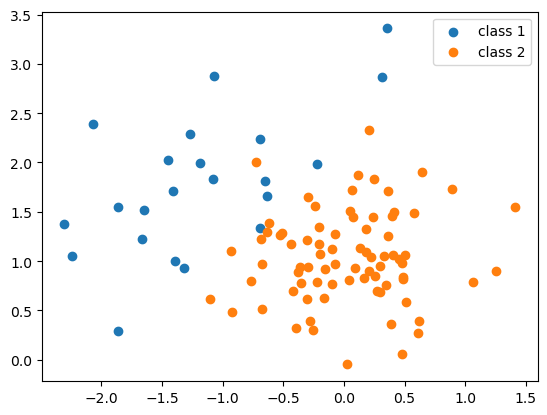

In [1]:
# your code
import numpy as np
import matplotlib.pyplot as plt

# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',')
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]

x_train_class1 = x_train[class_train == 1]
x_train_class2 = x_train[class_train == 2]
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], label = 'class 1')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], label = 'class 2')
plt.legend(loc=0)
plt.show()


2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


**Answer:**

In [2]:
# your code
test = np.loadtxt('data/synth_test.txt')
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]

def knn_classification(x_train, class_train, x_test, K):
    N_test = x_test.shape[0]
    class_pred = np.zeros(N_test)

    for q in range(N_test):
        distances = np.linalg.norm(x_train - x_test[q, np.newaxis], axis=1)

        nearest_neighbors = np.argsort(distances)[:K]
        nearest_labels = class_train[nearest_neighbors]

        class_pred[q] = np.bincount(nearest_labels.astype(int)).argmax()

    return class_pred

In [3]:
%timeit knn_classification(x_train, class_train, x_test, 10)

2.5 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


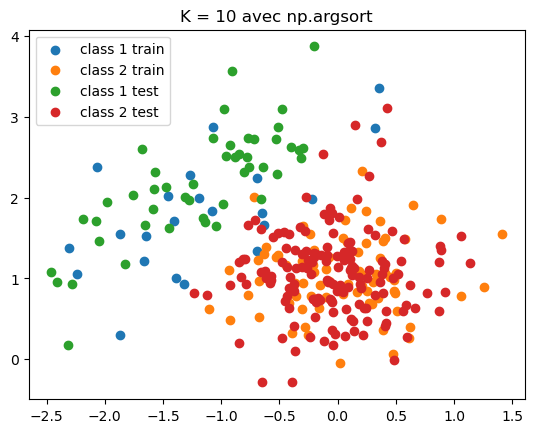

In [41]:
# Test
label_pred = knn_classification(x_train, class_train, x_test, 10)

x_train_class1 = x_train[class_train == 1]
x_train_class2 = x_train[class_train == 2]
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], label = 'class 1 train')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], label = 'class 2 train')


x_test_pred1 = x_test[label_pred == 1]
x_test_pred2 = x_test[label_pred == 2]
plt.scatter(x_test_pred1[:, 0], x_test_pred1[:, 1], label = 'class 1 test')
plt.scatter(x_test_pred2[:, 0], x_test_pred2[:, 1], label = 'class 2 test')

plt.title('K = 10 avec np.argsort')
plt.legend(loc=0)
plt.show()

In [42]:
import bottleneck

In [43]:
def knn_classification_bottleneck_argpartition(x_train, class_train, x_test, K):
    N_test = x_test.shape[0]
    class_pred = np.zeros(N_test)

    for q in range(N_test):
        distances = np.linalg.norm(x_train - x_test[q, np.newaxis], axis=1)

        nearest_neighbors = bottleneck.argpartition(distances, kth = K)[:K]
        nearest_labels = class_train[nearest_neighbors]

        class_pred[q] = np.bincount(nearest_labels.astype(int)).argmax()

    return class_pred

In [44]:
%timeit knn_classification_bottleneck_argpartition(x_train, class_train, x_test, 10)

2.96 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


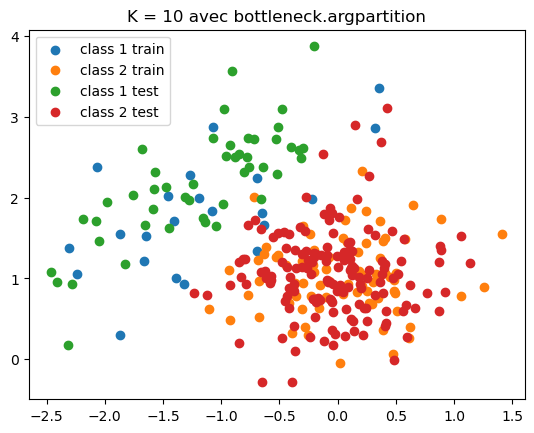

In [45]:
label_pred = knn_classification_bottleneck_argpartition(x_train, class_train, x_test, 10)

x_train_class1 = x_train[class_train == 1]
x_train_class2 = x_train[class_train == 2]
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], label = 'class 1 train')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], label = 'class 2 train')


x_test_pred1 = x_test[label_pred == 1]
x_test_pred2 = x_test[label_pred == 2]
plt.scatter(x_test_pred1[:, 0], x_test_pred1[:, 1], label = 'class 1 test')
plt.scatter(x_test_pred2[:, 0], x_test_pred2[:, 1], label = 'class 2 test')

plt.title('K = 10 avec bottleneck.argpartition')
plt.legend(loc=0)
plt.show()

L'utilisation de bottleneck.argpartition à la place de np.argsort permet de réduire le temps d'exécution de 3.06 ms à 2.66 ms. C'est donc un gain de performance qui pourrait être plus significatif sur des données de plus grande taille.

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

Text(0, 0.5, 'error rate')

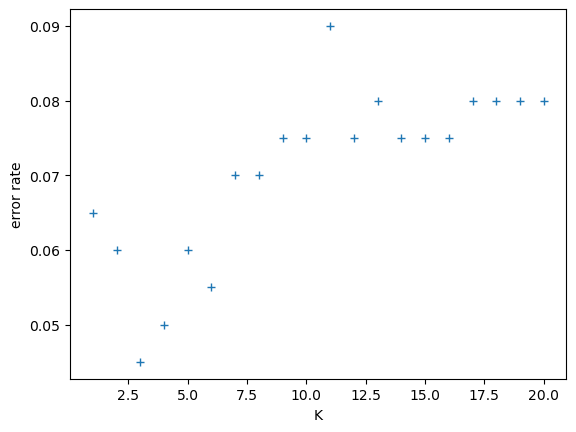

In [46]:
# your code
Errors = []
K_list = np.arange(1,21)

for K in K_list:
    label_pred = knn_classification(x_train, class_train, x_test, K)
    nb_good = np.sum(test[:, 0] == label_pred)
    error_rate = 1 - nb_good/x_test.shape[0]
    Errors.append(error_rate)

plt.plot(K_list, Errors, '+')
plt.xlabel('K')
plt.ylabel('error rate')

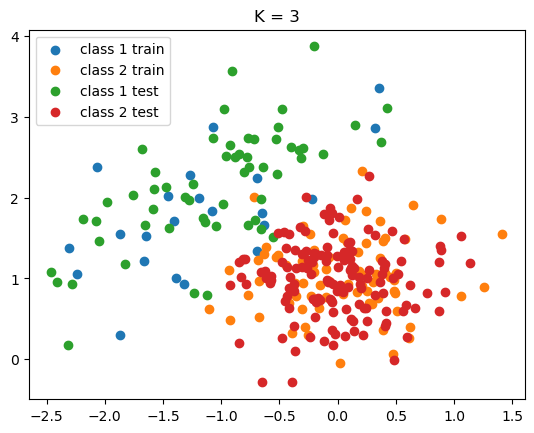

In [47]:
# Avec K = 3 :
label_pred = knn_classification(x_train, class_train, x_test, 3)

x_train_class1 = x_train[class_train == 1]
x_train_class2 = x_train[class_train == 2]
plt.scatter(x_train_class1[:,0], x_train_class1[:,1], label = 'class 1 train')
plt.scatter(x_train_class2[:,0], x_train_class2[:,1], label = 'class 2 train')

x_test_pred1 = x_test[label_pred == 1]
x_test_pred2 = x_test[label_pred == 2]
plt.scatter(x_test_pred1[:, 0], x_test_pred1[:, 1], label = 'class 1 test')
plt.scatter(x_test_pred2[:, 0], x_test_pred2[:, 1], label = 'class 2 test')

plt.title('K = 3')
plt.legend(loc=0)
plt.show()

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

On observe bien 2 clusters pour l'ensemble de test qui correspondent aux deux clusters de l'ensemble de train. En utilisant le taux d'erreur comme classificateur de l'erreur, on observe que le minimum est obtenu pour $K=3$ et il vaut $4.5$%. On observe que pour $K>10$, le taux d'erreur se stabilise vers $8$%.

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [48]:
# your code
from sklearn.neighbors import KNeighborsClassifier
import timeit

def run_our_knn():
    label_pred_custom = knn_classification(x_train, class_train, x_test, 3)
    return label_pred_custom

time_our_knn = timeit.timeit('run_our_knn()', globals=globals(), number=1000) / 1000



def run_sklearn_knn():
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(x_train, class_train)
    pred_sklearn = neigh.predict(x_test)
    return pred_sklearn

time_sklearn_knn = timeit.timeit('run_sklearn_knn()', globals=globals(), number=1000) / 1000


label_pred_our = run_our_knn()
label_pred_sklearn = run_sklearn_knn()

error_rate_our = 1 - np.sum(test[:, 0] == label_pred_our) / x_test.shape[0]
error_rate_sklearn = 1 - np.sum(test[:, 0] == label_pred_sklearn) / x_test.shape[0]

print(f"Our KNN Accuracy: {error_rate_our:.3f}")
print(f"Sklearn KNN Accuracy: {error_rate_sklearn:.3f}")

print(f"Our KNN time: {time_our_knn:.5f} seconds")
print(f"Sklearn KNN time: {time_sklearn_knn:.5f} seconds")

Our KNN Accuracy: 0.045
Sklearn KNN Accuracy: 0.045
Our KNN time: 0.00340 seconds
Sklearn KNN time: 0.00339 seconds


On trouve le même error rate pour $K=3$ entre notre version de KNN-neighbors et celle de sklearn : $error rate = 0.045$.
Notre version est un peu plus rapide.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

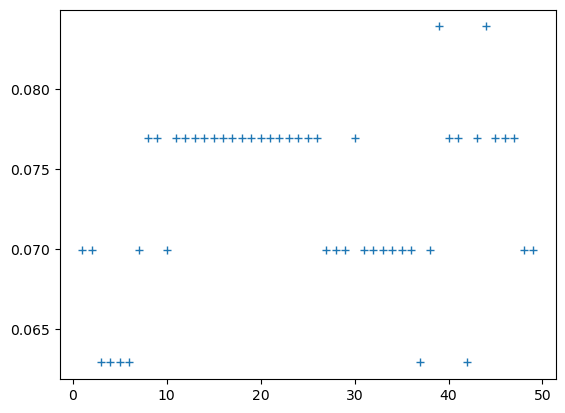

In [49]:
# your code
from sklearn.model_selection import train_test_split

data = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
data_train, data_test = train_test_split(data)

x_train = data_train[:, 2:]
class_train = data_train[:, 1]
x_test = data_test[:, 2:]

Errors=[]
for K in range(1, 50):
    preds = knn_classification(x_train, class_train, x_test, K)

    error_rate = 1 - np.sum(data_test[:, 1] == preds)/x_test.shape[0]
    Errors.append(error_rate)

plt.plot(range(1,50), Errors, '+')

En utilisant notre méthode, on trouve encore un K optimal : $K=10$. On constate qu'en utilisant la fonction train_test_split du module sklearn, le cas optimal est souvent pour K=10 mais l'erreur peut varier en fonction du split effectué, entre 3 et 8 %.

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [50]:
!cd example_cy && python setup.py build_ext --inplace

Compiling helloworld.pyx because it changed.
Compiling primes.pyx because it changed.
[1/2] Cythonizing helloworld.pyx
[2/2] Cythonizing primes.pyx
helloworld.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-311\Release\helloworld.cp311-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-311\Release\helloworld.cp311-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code
primes.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-311\Release\primes.cp311-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-311\Release\primes.cp311-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


In [51]:
#import example_cy.example_cy.helloworld as toy
import example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

Remarque : j'ai supprimé le fichier ``__init__.py`` car sinon on avait une erreur lors de la compilation

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

Answer: On compile compute_cy et on mesure le temps d'exécution :

In [53]:
!cd example_np_cy && python setup.py build_ext --inplace

Compiling compute_cy.pyx because it changed.
[1/1] Cythonizing compute_cy.pyx
compute_cy.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-311\Release\compute_cy.cp311-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-311\Release\compute_cy.cp311-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


In [54]:
import numpy as np

In [55]:
import example_np_cy.compute_cy as toy_np

array_1 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
array_2 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
a = 4
b = 3
c = 9

toy_np.compute(array_1, array_2, a, b, c)

array([[3004,  310, 1003, ...,   55, 2746, 1702],
       [ 595,  934, 1342, ..., 1876, 1498, 1609],
       [2557,  205, 2467, ...,  769,  874, 1105],
       ...,
       [1816,  787, 2155, ..., 2857,  259,  376],
       [ 427,  988,  919, ..., 1813,  865, 1129],
       [1081,  751, 1105, ..., 2065, 1198,  181]], dtype=int32)

In [56]:
%timeit toy_np.compute(array_1, array_2, a, b, c)

2.59 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Le code de la fonction compute est déjà optimisé en ajoutant les types des variables utilisées. On constate sur le fichier html que la partie qui reste à optimiser (celle surlignée de la couleur la plus foncée) est celle-ci : 
```
tmp = clip(array_1[x, y], 2, 10)   
tmp = tmp * a + array_2[x, y] * b   
result[x, y] = tmp + c
```  
On optimise le code en utilisant memoryview pour pointer vers les arrays numpy et donc utiliser C au lieu de numpy pour certaines opérations ce qui permet d'améliorer le temps d'exécution.
```  
cdef int[:, :] result_view = result   
```   
suivi de l'utilisation de result_view à la place de result permet donc d'utiliser l'array result avec une structure C.

In [57]:
!cd example_np_cy_memoryviews && python setup.py build_ext --inplace

Compiling compute_cy_memoryviews.pyx because it changed.
[1/1] Cythonizing compute_cy_memoryviews.pyx
compute_cy_memoryviews.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-311\Release\compute_cy_memoryviews.cp311-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-311\Release\compute_cy_memoryviews.cp311-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


In [58]:
import example_np_cy_memoryviews.compute_cy_memoryviews as toy_np_memoryviews

toy_np_memoryviews.compute(array_1, array_2, a, b, c)

array([[3004,  310, 1003, ...,   55, 2746, 1702],
       [ 595,  934, 1342, ..., 1876, 1498, 1609],
       [2557,  205, 2467, ...,  769,  874, 1105],
       ...,
       [1816,  787, 2155, ..., 2857,  259,  376],
       [ 427,  988,  919, ..., 1813,  865, 1129],
       [1081,  751, 1105, ..., 2065, 1198,  181]], dtype=int32)

In [59]:
%timeit toy_np_memoryviews.compute(array_1, array_2, a, b, c)

26.3 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


L'utilisation de memoryviews permet donc de passer de 2.22 s d'exécution à seulement 19 ms pour la fonction compute.

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

On réalise une première version V1 du code optimisé avec cython dans lequel on a initialisé toutes les variables de type array avec np.zeros, on a remplacé le calcul de la distance par une boucle for au lieu de np.linalg.norm, et on a modifie toujours les arrays en affectant des valeurs à une certaine position au lieu de laisser numpy faire toutes les affectations automatiquement.

In [4]:
!cd knn_classifier_V1 && python setup.py build_ext --inplace

Compiling knn_classifier_V1.pyx because it changed.
[1/1] Cythonizing knn_classifier_V1.pyx
knn_classifier_V1.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-311\Release\knn_classifier_V1.cp311-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-311\Release\knn_classifier_V1.cp311-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


In [5]:
import knn_classifier_V1.knn_classifier_V1 as toy_knn_classifier_V1

toy_knn_classifier_V1.knn_classification(x_train, class_train, x_test, 10)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2.,
       1., 1., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2., 1., 2., 1., 2., 1.,
       2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2.,
       1., 1., 1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 1., 1., 1., 2., 1., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1.,
       2., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 1., 2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1.])

In [6]:
%timeit toy_knn_classifier_V1.knn_classification(x_train, class_train, x_test, 10)

14.4 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On réalise ensuite une deuxième version V2 du code optimisé avec cython en utilisant des memory view pour accéder aux arrays et en précisant les types des arrays en paramètres de la fonction.

In [3]:
!cd knn_classifier_V2 && python setup.py build_ext --inplace

Compiling knn_classifier_V2.pyx because it changed.
[1/1] Cythonizing knn_classifier_V2.pyx
knn_classifier_V2.c
   Cr�ation de la biblioth�que build\temp.win-amd64-cpython-311\Release\knn_classifier_V2.cp311-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-311\Release\knn_classifier_V2.cp311-win_amd64.exp
G�n�ration de code en cours
Fin de la g�n�ration du code


In [4]:
import knn_classifier_V2.knn_classifier_V2 as toy_knn_classifier_V2

toy_knn_classifier_V2.knn_classification(x_train, class_train, x_test, 10)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2.,
       1., 1., 2., 2., 1., 2., 1., 2., 2., 1., 2., 2., 1., 2., 1., 2., 1.,
       2., 2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2.,
       1., 1., 1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 1., 1., 1., 2., 1., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1.,
       2., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
       2., 1., 2., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1.])

In [5]:
%timeit toy_knn_classifier_V2.knn_classification(x_train, class_train, x_test, 10)

2.6 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Enfin, on réalise une troisième version V3 du code optimisé avec cython en ajoutant @cython.boundscheck(False) et @cython.wraparound(False) pour optimiser encore plus le code.

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [ ]:
# your code

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [ ]:
# your code

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [ ]:
# your code